# Introducing Model Fitting

Astronomers often model observational data—such as light curves, spectral lines, or galaxy scaling relations—by fitting theoretical functions to measured values. The curve_fit function from scipy.optimize allows for flexible, non-linear least-squares fitting. You define a model (e.g., a Gaussian, power law, or exponential), and curve_fit finds the best-fit parameters that minimize the residuals between the model and data.

In [1]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

When the relationship between variables appears roughly linear or polynomial, np.polyfit is a fast and easy tool. It fits a polynomial of a specified degree to the data using a least-squares approach. While not as flexible as curve_fit, it's great for fitting trends like stellar mass–metallicity relations or photometric calibrations.

Use curve_fit when you have a physically motivated, non-linear model.

Use np.polyfit when you're exploring trends or approximating smooth curves with polynomials.



In [2]:
## Generating the Data
np.random.seed(23423432)
#  1. Polynomial data (e.g., stellar mass–metallicity relation)
x_poly = np.linspace(-5, 5, 50)
y_poly = 2.5 * x_poly**2 - 1.3 * x_poly + 0.5 + np.random.normal(0, 5, size=x_poly.shape)

# 2. Gaussian data (e.g., emission line)
x_gauss = np.linspace(-10, 10, 100)
true_params = [10, 0, 2]  # amplitude, mean, stddev
y_gauss = true_params[0] * np.exp(-(x_gauss - true_params[1])**2 / (2 * true_params[2]**2))
y_gauss += np.random.normal(0, 2, size=x_gauss.shape)


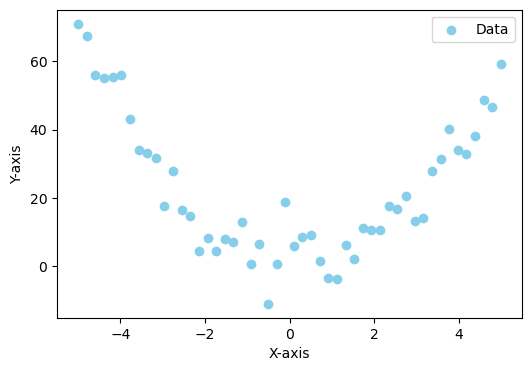

In [3]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

# Plot polynomial fit
axs.scatter(x_poly, y_poly, label="Data", color='skyblue')
axs.set_xlabel("X-axis")
axs.set_ylabel("Y-axis")
axs.legend()


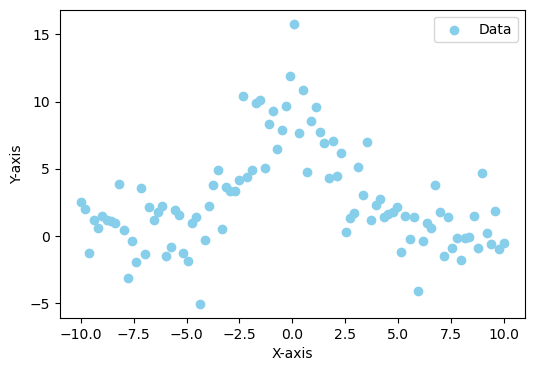

In [4]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

# Plot polynomial fit
axs.scatter(x_gauss, y_gauss, label="Data", color='skyblue')
axs.set_xlabel("X-axis")
axs.set_ylabel("Y-axis")
axs.legend()


In [5]:
# Polynomial fit (1nd degree)
coeffs = np.polyfit(x_poly, y_poly, deg=1)
poly_fit_linear = np.poly1d(coeffs)

In [6]:
# Polynomial fit (2nd degree)
coeffs = np.polyfit(x_poly, y_poly, deg=2)
poly_fit_quad = np.poly1d(coeffs)

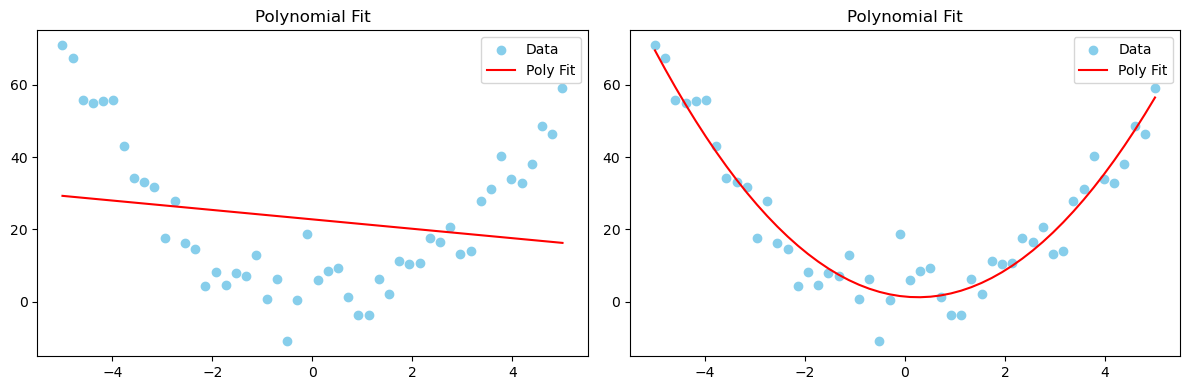

In [7]:

fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot polynomial fit
axs[0].scatter(x_poly, y_poly, label="Data", color='skyblue')
axs[0].plot(x_poly, poly_fit_linear(x_poly), color='red', label="Poly Fit")
axs[0].set_title("Polynomial Fit")
axs[0].legend()


axs[1].scatter(x_poly, y_poly, label="Data", color='skyblue')
axs[1].plot(x_poly, poly_fit_quad(x_poly), color='red', label="Poly Fit")
axs[1].set_title("Polynomial Fit")
axs[1].legend()

plt.tight_layout()
plt.show()

In [8]:
# Goodness fo fit

def rss(y_obs, y_model):
    """
    Compute the Residual Sum of Squares (RSS) between observed and model values.

    Parameters:
    -----------
    y_obs : array-like
        Observed data points.
    y_model : array-like
        Model-predicted values at the same x-values.

    Returns:
    --------
    float
        The residual sum of squares.
    """
    residuals = y_obs - y_model
    return np.sum(residuals**2)


def reduced_chi2(y_obs, y_model, y_err, dof=None):
    """
    Compute the reduced chi-squared statistic.

    Parameters:
    -----------
    y_obs : array-like
        Observed data points.
    y_model : array-like
        Model-predicted values.
    y_err : array-like
        Uncertainties on the observed data.
    dof : int, optional
        Degrees of freedom. If None, defaults to len(y_obs) - 1.

    Returns:
    --------
    float
        The reduced chi-squared value.
    """
    if dof is None:
        dof = len(y_obs) - 1
    chi2 = np.sum(((y_obs - y_model) / y_err) ** 2)
    return chi2 / dof

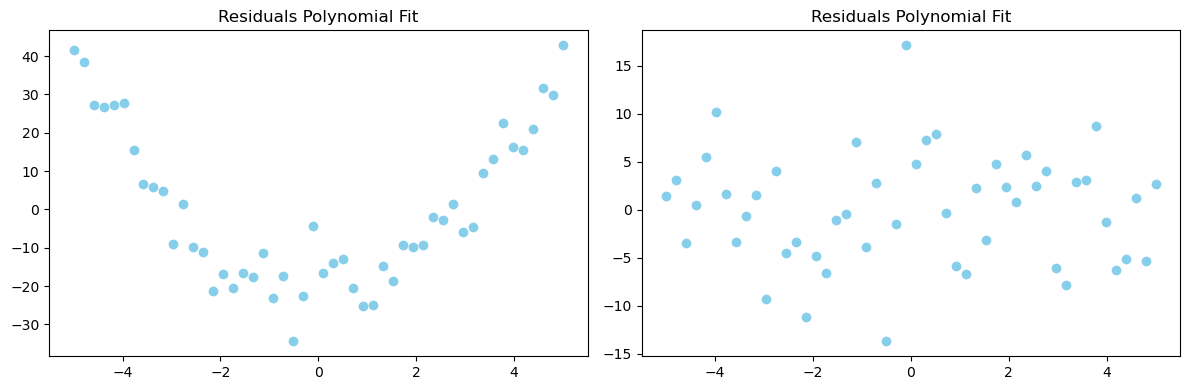

In [9]:
residuals_linear = y_poly - poly_fit_linear(x_poly)
residuals_quad = y_poly - poly_fit_quad(x_poly)


fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot polynomial fit
axs[0].scatter(x_poly, residuals_linear, color='skyblue')
axs[0].set_title("Residuals Polynomial Fit")


axs[1].scatter(x_poly, residuals_quad, color='skyblue')
axs[1].set_title("Residuals Polynomial Fit")

plt.tight_layout()
plt.show()

In [10]:
y_model_linear = poly_fit_linear(x_poly)
y_model_quad = poly_fit_quad(x_poly)

rss_linear = rss(y_poly, y_model_linear)
rss_quad = rss(y_poly, y_model_quad)
print()
print(f"RSS (Linear Fit): {rss_linear}")
print(f"RSS (Quadratic Fit): {rss_quad}")

# Reduced Chi-squared
reduced_chi2_linear = reduced_chi2(y_poly, y_model_linear, y_err=1.5*np.ones_like(y_poly))
reduced_chi2_quad = reduced_chi2(y_poly, y_model_quad, y_err=1.5*np.ones_like(y_poly))
print()
print(f"Reduced Chi-squared (Linear Fit): {reduced_chi2_linear}")
print(f"Reduced Chi-squared (Quadratic Fit): {reduced_chi2_quad}")


RSS (Linear Fit): 19898.38862234653
RSS (Quadratic Fit): 1668.7915273008036

Reduced Chi-squared (Linear Fit): 180.48425054282563
Reduced Chi-squared (Quadratic Fit): 15.136431086628605


In [19]:
# Gaussian fit using curve_fit
def gaussian(x, amp, mu, sigma):

    '''
    Gaussian function for curve fitting.
    Parameters:
    -----------
    x : array-like
        Independent variable.
    amp : float
        Amplitude of the Gaussian.
    mu : float
        Mean of the Gaussian.
    sigma : float
        Standard deviation of the Gaussian.
    Returns:
    --------
    array-like
        Gaussian function evaluated at x.

    '''
    
    return amp * np.exp(-(x - mu)**2 / (2 * sigma**2))


low_bounds = [0, -np.inf, 0]
high_bounds = [np.inf, np.inf, np.inf]

popt, pcov = curve_fit(gaussian, 
                       x_gauss, 
                       y_gauss, 
                       p0=[8, 0, 1], 
                       bounds = [low_bounds, high_bounds])

In [24]:
pcov

array([[ 4.72121983e-01, -7.85077704e-09,  1.26978370e-01],
       [-7.85077704e-09,  1.02453429e-01, -6.99378128e-10],
       [ 1.26978370e-01, -6.99378128e-10,  1.02453437e-01]])

In [36]:
var1, var2, (a, b, c) = test()

In [34]:
c

42323

In [30]:
var3

[423, 32423, 42323]

In [17]:
list_test = [ 9.70506041, -0.09961689,  2.048054  ]

In [16]:
popt

array([ 9.70506041, -0.09961689,  2.048054  ])

In [18]:
#gaussian(x, amp, mu, sigma)
#gaussian(x_gauss, popt[0], popt[1], popt[2])
gaussian(x_gauss, *list_test)

array([8.17910151e-05, 1.31122622e-04, 2.08172820e-04, 3.27299090e-04,
       5.09612351e-04, 7.85795371e-04, 1.19992295e-03, 1.81456123e-03,
       2.71746694e-03, 4.03024347e-03, 5.91933162e-03, 8.60970821e-03,
       1.24016242e-02, 1.76906209e-02, 2.49909036e-02, 3.49619152e-02,
       4.84376254e-02, 6.64576296e-02, 9.02986428e-02, 1.21504391e-01,
       1.61911276e-01, 2.13666577e-01, 2.79235392e-01, 3.61392143e-01,
       4.63192292e-01, 5.87920108e-01, 7.39008916e-01, 9.19931343e-01,
       1.13405868e+00, 1.38449060e+00, 1.67385899e+00, 2.00411252e+00,
       2.37629146e+00, 2.79030505e+00, 3.24472607e+00, 3.73661854e+00,
       4.26141532e+00, 4.81286119e+00, 5.38303473e+00, 5.96245895e+00,
       6.54030490e+00, 7.10468720e+00, 7.64304299e+00, 8.14257966e+00,
       8.59077023e+00, 8.97587021e+00, 9.28742669e+00, 9.51674881e+00,
       9.65731034e+00, 9.70505816e+00, 9.65860646e+00, 9.51930348e+00,
       9.29116661e+00, 8.98068982e+00, 8.59653665e+00, 8.14913880e+00,
      

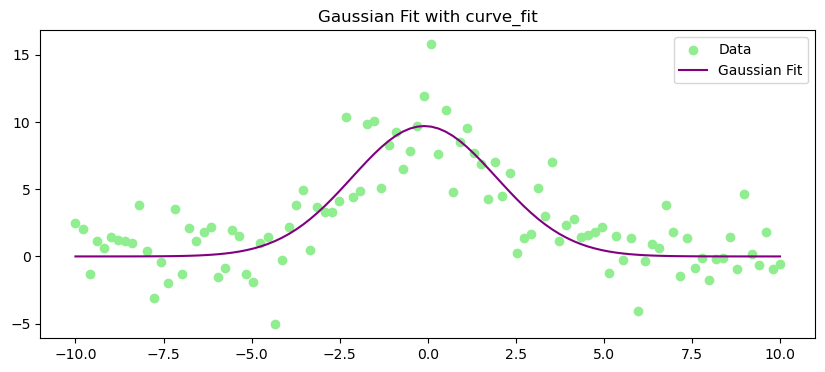

In [12]:
fig, axs = plt.subplots(1, 1, figsize=(10, 4))

# Plot Gaussian fit
axs.scatter(x_gauss, y_gauss, label="Data", color='lightgreen')
axs.plot(x_gauss, gaussian(x_gauss, *popt), color='purple', label="Gaussian Fit")
axs.set_title("Gaussian Fit with curve_fit")
axs.legend()

plt.show()

In [13]:
# 3. Gaussian data (e.g., absorption line)
x_gauss = np.linspace(-10, 10, 100)
true_params = [-5, 0, 2]  # amplitude, mean, stddev
y_gauss2 = true_params[0] * np.exp(-(x_gauss - true_params[1])**2 / (2 * true_params[2]**2))
y_gauss2 += np.random.normal(0, 2, size=x_gauss.shape)

In [14]:
#low_bounds = [0, -np.inf, 0]
#high_bounds = [np.inf, np.inf, np.inf]

popt2, pcov = curve_fit(gaussian, 
                       x_gauss, 
                       y_gauss2, 
                       p0=[-3, 0, 1])

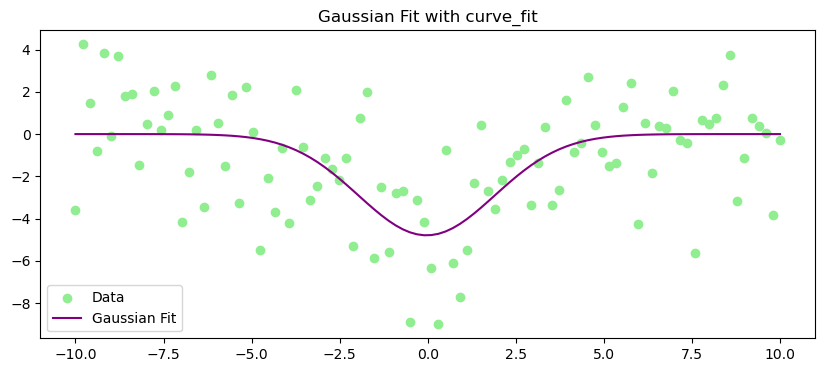

In [15]:
fig, axs = plt.subplots(1, 1, figsize=(10, 4))

# Plot Gaussian fit
axs.scatter(x_gauss, y_gauss2, label="Data", color='lightgreen')
axs.plot(x_gauss, gaussian(x_gauss, *popt2), color='purple', label="Gaussian Fit")
axs.set_title("Gaussian Fit with curve_fit")
axs.legend()

plt.show()